# Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [65]:
## 1. Import necessars libraries

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


## 2. Inspect data

In [2]:
# dimensions of experiment

n_total = train_data.shape[0]
print('n_total:', n_total)

n_control = train_data.query('Promotion == "No"').shape[0]
print('n_control:', n_control)

n_experiment = train_data.query('Promotion == "Yes"').shape[0]
print('n_experiment:', n_experiment)

n_total: 84534
n_control: 42170
n_experiment: 42364


In [3]:
# investigate datatypes
train_data.dtypes

ID             int64
Promotion     object
purchase       int64
V1             int64
V2           float64
V3           float64
V4             int64
V5             int64
V6             int64
V7             int64
dtype: object

In [4]:
# total number of purchases

purchases_total = train_data.query('purchase == 1').shape[0]
print('purchases_total:', purchases_total)

purchases_control = train_data.query('Promotion == "No" and purchase == 1').shape[0]
print('purchases_control:', purchases_control)

purchases_experiment = train_data.query('Promotion == "Yes" and purchase == 1').shape[0]
print('purchases_experiment:', purchases_experiment)

purchases_total: 1040
purchases_control: 319
purchases_experiment: 721


In [5]:
# proportion of customers who bought the product

proportion_total = train_data.purchase.mean()
print('proportion_total:', proportion_total)

proportion_control = train_data.query('Promotion == "No"').purchase.mean()
print('proportion_control:', proportion_control)

proportion_experiment = train_data.query('Promotion == "Yes"').purchase.mean()
print('proportion_experiment:', proportion_experiment)

proportion_total: 0.012302742091939338
proportion_control: 0.007564619397676073
proportion_experiment: 0.017019167217448776


## 3. Calculate metrics

In [7]:
# Incremental Response Rate (IRR)

IRR_observed = proportion_experiment - proportion_control
print('Incremental Response Rate (IRR):', IRR_observed)

Incremental Response Rate (IRR): 0.009454547819772702


The Incremental Response Rate (IRR) is 0.0095. This seems as there is a positive effect regarding additional purchases by making advertising promotion. If this observed difference is statistically significant, will be answered in the Hypothesis test.

In [8]:
# Net Incremental Revenue (NIR)

NIR_observed = (10 * purchases_experiment - 0.15 * n_experiment) - 10 * purchases_control
print('Net Incremental Revenue (NIR):', NIR_observed)

Net Incremental Revenue (NIR): -2334.5999999999995


The Net Incremental Revenue (NIR) is -2334, which indicates that the cost of the advertising promotions is higher than the additional sold units. The chance of observing this value as part of a normal distribution with its mean greater than zero will be calculated in the Hypothesis tests.

## 4. Hypothesis test

1. Build user Funnel --> not relevant here
2. Diversion of Users (event-based. cookie-based, account-based) --> not relevant here
3. Selcting Invariant Metric: Distribution of customers to control group and experiment group.
4. Selecting Evaluation Metric(s): IRR & NIR
5. Use Correction (Bonferroni, Sidark): Bonferroni, because there are two evaluation metrics
6. Experiment size: --> not relevant here
7. Validity, Bias, Ehtics: --> not relevant here
8. Analyze Data: --> not relevant here

### 4.1 Checking the Invariant Metric:

We will check that the number of customers assigned to each group is similar. It's important to check the invariant metrics as a prerequisite so that the following inferences on the evaluation metrics are founded on solid ground. 

In this a two-sided hypothesis test will be performed on the proportion of visitors assigned to one of the conditions. Choosing the control or the experimental condition doesn't matter, there will be the same result either way.

The Null-Hypothesis $H_0$ states that the customers are equally distributed among control group and experimental group. The alternetive Hypothesis $H_1$ states that the amount of customers in control group and experimental group are different.

#### 4.1.1 Analytical approach:

In [9]:
# Compute a z-score and p-value
probability = 0.5
standard_deviation = np.sqrt(probability * (1-probability) * n_total)

print('The standard deviation for a normal distribution with {} customers and a probability of {} is: {}'.format(
    n_total, probability, standard_deviation))

z_score = ((n_control + 0.5) - probability * n_total) / standard_deviation

print('The probabilty of seeing the observed amount of users ({}) in the control group or a more extreme value \
        under the Null-Hypothesis, is {}'.format(n_control, 2 * stats.norm.cdf(z_score)))

The standard deviation for a normal distribution with 84534 customers and a probability of 0.5 is: 145.3736564856233
The probabilty of seeing the observed amount of users (42170) in the control group or a more extreme value         under the Null-Hypothesis, is 0.5068140685419046


#### 4.1.2 Empirical / Simulation-based approach:

In [10]:
# Simulate outcomes under null, compare to observed outcome
n_trials = 200000

samples = np.random.binomial(n_total, probability, n_trials)

print()

print('The probabilty of seeing the observed amount of users ({}) in the control group or a more extreme value \
        under the Null-Hypothesis, is {}'.format(
    n_control, np.logical_or(samples <= n_control, samples >= (n_total - n_control)).mean()))


The probabilty of seeing the observed amount of users (42170) in the control group or a more extreme value         under the Null-Hypothesis, is 0.50663


This prooves that the distribution of customers to control and experimental group, as seen in the train_data file, is similar. The next stept is to perform the Hypothesis tests on the evaluation metrics.

### 4.2 Hypothesis regarding the Incremental Response Rate (IRR):

The first evaluation metric is the Incremental Response Rate (IRR). The goal of the advertisement promotion is that the experimental group has a significantly larger proportion of customers who buy the product than the control group.

The Hypothesis test will be performed analytical and with the simulation approach. It will be a one-tailed test.
The Null Hypothesis states that Incremental Response Rate (IRR) is zero or less, meaning that the experimental group which received the advertisement promotion did not actually buy more units than the control group. The alternative Hypothesis states that there is a positive IRR:

* $H_0: IRR \leq 0$
* $H_1: IRR > 0$

As we use two evaluation metrics we need to adjust the accepted level of false-postitives with a Bonferroni Correction, where $\frac{\alpha}{n_{eval metrics}}$
* $\alpha = 2.5\% = 0.025$

Question to answer:

Is it less probable than alpha = 2.5% to have the observed difference of IRR = 0.009454, assuming there is no difference in Incremental Response between those who receive a a promotion and those who not.

#### 4.2.1 Analytical approach:

In [12]:
# proportion pooled
proportion_pooled = proportion_total

# Standard Error pooled
standard_error_pooled = np.sqrt(proportion_pooled * (1-proportion_pooled) * (1/n_control + 1/n_experiment))
print('Pooled Standard Error:', standard_error_pooled)

# observed difference
difference = IRR_observed # = proportion_experiment - proportion_control
print('Observed difference in IRR:', difference)

# z-score
z_score = difference / standard_error_pooled
print('z-score:', z_score)

print('Probabilty seeing observed difference in IRR, when H0 is true:', 1-stats.norm.cdf(z_score)) 

Pooled Standard Error: 0.00075827775128664
Observed difference in IRR: 0.009454547819772702
z-score: 12.468449461599388
Probabilty seeing observed difference in IRR, when H0 is true: 0.0


#### 4.2.2 Empirical / Simulation-based approach:

Probabilty seeing observed difference in IRR, when H0 is true: 0.0


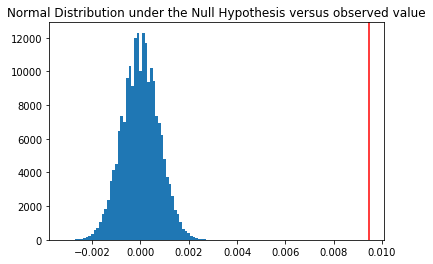

In [14]:
# Simulate outcomes under null, compare to observed outcome
n_trials = 200000

# Create 200000 test runs for control and experimental group with H0 saying that both groups have 
# the same IRR = proportion_total
experiment_sampled = np.random.binomial(n_experiment, proportion_total, n_trials)
control_sampled = np.random.binomial(n_control, proportion_total, n_trials)

# Calculate IRR for each test run and get difference 
# of distributions
samples = experiment_sampled / n_experiment - control_sampled / n_control

# Distribution were created believing in H0: There is no difference 
#in center (both p_total)

# Now calculate proportion of samples with same or more extreme 
# difference in click-through-rate than observed difference
print('Probabilty seeing observed difference in IRR, when H0 is true:',
      (samples >= (proportion_experiment - proportion_control)).mean())

plt.axvline(proportion_experiment - proportion_control, color='r', label ="Observed Statistic") 
plt.hist(samples, bins=60);
plt.title("Normal Distribution under the Null Hypothesis versus observed value");

The graphic above shows clearly that assuming that under the null hypothesis it is not possible to observe the value for IRR we actually observed in the experiment. This means that without a doubt the advertisement promotion had a positive effect on unit bought. This does not answer if the money earned by the additional units sold pays the costs for the advertisement. This will be answered in the next chapter.

### 4.3 Hypothesis regarding the Net Incremental Revenue (NIR):

The second evaluation metric is the Net Incremental Revenue (NIR). In this case, the goal is to proove that the money spent for the promotion will be compensated by the addtional revenue in the experimental group. 

This time the Hypothesis test will only performed with a simulation approach. The test will be a one-tailed test.

The Null Hypothesis states that the Net Incremental Revenue (NIR) is zero or negative. The alternative Hypothesis states that NIR is greater than zero.


* $H_0: NIR \leq 0$
* $H_1: NIR > 0$

With a Bonferroni Correction, where $\frac{\alpha}{n_{evaluation metrics}}$
* $\alpha = 2.5\% = 0.025$

#### 4.3.1 Empirical / Simulation-based approach:

In [28]:
n_trials = 10000
NIR = []

for trial in range(n_trials):
    sample = train_data.sample(round(n_total*0.2), replace=True)
    sample_purchases_experiment = sample.query('Promotion == "Yes" and purchase == 1').shape[0]
    sample_purchases_control = sample.query('Promotion == "No" and purchase == 1').shape[0]
    sample_n_experiment = sample.query('Promotion == "Yes"').shape[0]
    NIR.append((10 * sample_purchases_experiment - 0.15 * sample_n_experiment) - 10 * sample_purchases_control)

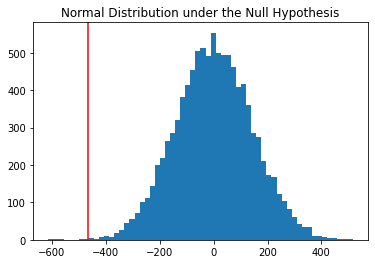

In [40]:
null_distr = np.random.normal(0, np.std(NIR), n_trials)
plt.hist(null_distr, bins=60)
plt.axvline(NIR_observed * round(n_total*0.2)/train_data.shape[0], color='r', label ="Observed Statistic")
plt.title("Normal Distribution under the Null Hypothesis");

In [ ]:
((NIR_observed * n_total*0.2/train_data.shape[0]) > np.array(NIR)).mean()

If we use only a sample with 20% size of the orginal data, the metric FIR hast to be scaled with the same factor 0.2 = round(n_total*0.2)/train_data.shape[0] 

The graphic above shows that the null hypothesis can not be rejected. The observed value for NIR is negative and can not even be observed assuming a mean of zero. Therefore there is no possibility this value can be observed in a distribution with a positive mean value.

### 5. Create a Model to maximize IRR and NIR

In [66]:
X = train_data.drop(['purchase'],axis=1)
y = train_data.purchase

In [ ]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    
    
    
    return promotion

In [ ]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)